import gym
import torch
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from itertools import product
from stable_baselines3 import A2C
from pathlib import Path
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import time
import copy
from tqdm import trange
import os
import pandas as pd
import joblib
from copy import copy
from gym.wrappers import TimeLimit
from tqdm import tqdm, trange
from skmultiflow.lazy import KNNRegressor

In [1]:
from rl_ood import *

In [2]:
path = Path.cwd()
device = 'cpu'

# OOD environments instantiation

In [3]:
default_values, values = get_cartpole_values()

In [4]:
default_values

{'Gravity': 9.8,
 'Mass_cart': 1.0,
 'Length_pole': 0.5,
 'Mass_pole': 0.1,
 'Force_magnitude': 10.0}

In [5]:
def get_ood_configs(default_values, values):
    """
    Gives ood config that differ form the defalut config by only one value
    """
    ood_configs = []
    #changes = []
    for key in values:
        
        for value in values[key]:
            ood_config = copy(default_values)
            if value != default_values[key]:
                ood_config[key] = value
                ood_config['change'] = key
                ood_configs.append(ood_config)
                #changes.append({key:value})

    return ood_configs #, changes

ood_configs = get_ood_configs(default_values, values)
len(ood_configs)
ood_configs[0]

{'Gravity': 0.98,
 'Mass_cart': 1.0,
 'Length_pole': 0.5,
 'Mass_pole': 0.1,
 'Force_magnitude': 10.0,
 'change': 'Gravity'}

In [6]:
{'Force_magnitude': 70.0}.keys()

dict_keys(['Force_magnitude'])

In [7]:

ood_env = instanciate_cartpole(ood_configs[0])
print(ood_env)
ood_env.close()

<TimeLimit<CartPoleEnv<CartPole-v1>>>


In [8]:
def get_possible_combinaisons(values):
    return [x for x in product(*list(values.values()))]

# Evaluate OOD impact

### Original environment

In [9]:



def evaluate(env, agent, nb_episodes=100, render=False):
    total_rewards = []
    observation = env.reset()
    
    for ep in range(nb_episodes):
        total_reward = 0.0
        observation = env.reset()
        terminated = False
        
        while terminated is False:
            action, _state = agent.predict(observation)
            #action = env.action_space.sample()
            observation, reward, terminated, info = env.step(action)
            total_reward += reward

            if render:
                env.render()
                
        total_rewards.append(total_reward)

            
    env.close()
    
    return np.mean(total_rewards), np.std(total_rewards)



In [10]:
#agent = A2C.load(path/'Agents'/'Pendulum-v1.zip', env=env)

#agent = A2C.load(path/'Agents'/'CartPole-v1.zip', env=env)
env = instanciate_cartpole(default_values)

path_agent = path / 'Agents' / 'trained_CartPole_10000'
#if os.path.exists(path_agent):
#    agent = A2C.load(path_agent)
#else:
agent = A2C('MlpPolicy', env)
agent.learn(10000)
agent.save(path_agent)

evaluate(env, agent, nb_episodes=10, render=False)

(115.4, 46.55792091577974)

In [11]:
evaluate(env, agent, render=False)

(153.19, 94.92151442112583)

In [12]:
ood_configs[0]

{'Gravity': 0.98,
 'Mass_cart': 1.0,
 'Length_pole': 0.5,
 'Mass_pole': 0.1,
 'Force_magnitude': 10.0,
 'change': 'Gravity'}

In [13]:
default_values

{'Gravity': 9.8,
 'Mass_cart': 1.0,
 'Length_pole': 0.5,
 'Mass_pole': 0.1,
 'Force_magnitude': 10.0}

In [14]:
ood_env = instanciate_cartpole(ood_configs[0])
#agent = A2C.load(path/'Agents'/'CartPole-v1.zip', env=ood_env)
agent = A2C.load(path/'Agents'/'trained_CartPole_10000', env=ood_env)
evaluate(ood_env, agent, render=False)

(388.19, 54.74955616258456)

In [15]:
ood_env = instanciate_cartpole(ood_configs[-1])
print(ood_env.gravity)
evaluate(ood_env, agent, render=False)

9.8


(66.18, 49.342148311560166)

### Evaluation 

In [16]:
default_values, values = get_cartpole_values()
results = {}
std_results = {}

original_env = instanciate_cartpole(default_values)
agent = A2C.load(path/'Agents'/'trained_CartPole_10000', env=original_env)
original_result, original_std_result = evaluate(original_env, agent, render=False)

for config in tqdm(ood_configs):
    if config['change'] not in results:
        results[config['change']] = []
        std_results[config['change']] = []
    
    ood_env = instanciate_cartpole(config)
    agent = A2C.load(path/'Agents'/'trained_CartPole_10000', env=ood_env)
    mean_reward, std_reward = evaluate(ood_env, agent, nb_episodes=100)
    
    results[config['change']].append(mean_reward)
    std_results[config['change']].append(std_reward)
    #print(config, mean_reward)
    



100%|██████████| 90/90 [01:54<00:00,  1.28s/it]


In [17]:
L = copy(values['Gravity'])
L.append(9.8)
print(sorted(L))

[0.98, 1.09, 1.23, 1.4, 1.63, 1.96, 2.45, 3.27, 4.9, 9.8, 19.6, 29.4, 39.2, 49.0, 58.8, 68.6, 78.4, 88.2, 98.0]


In [18]:
original_result, original_std_result

(130.74, 84.4225822869687)

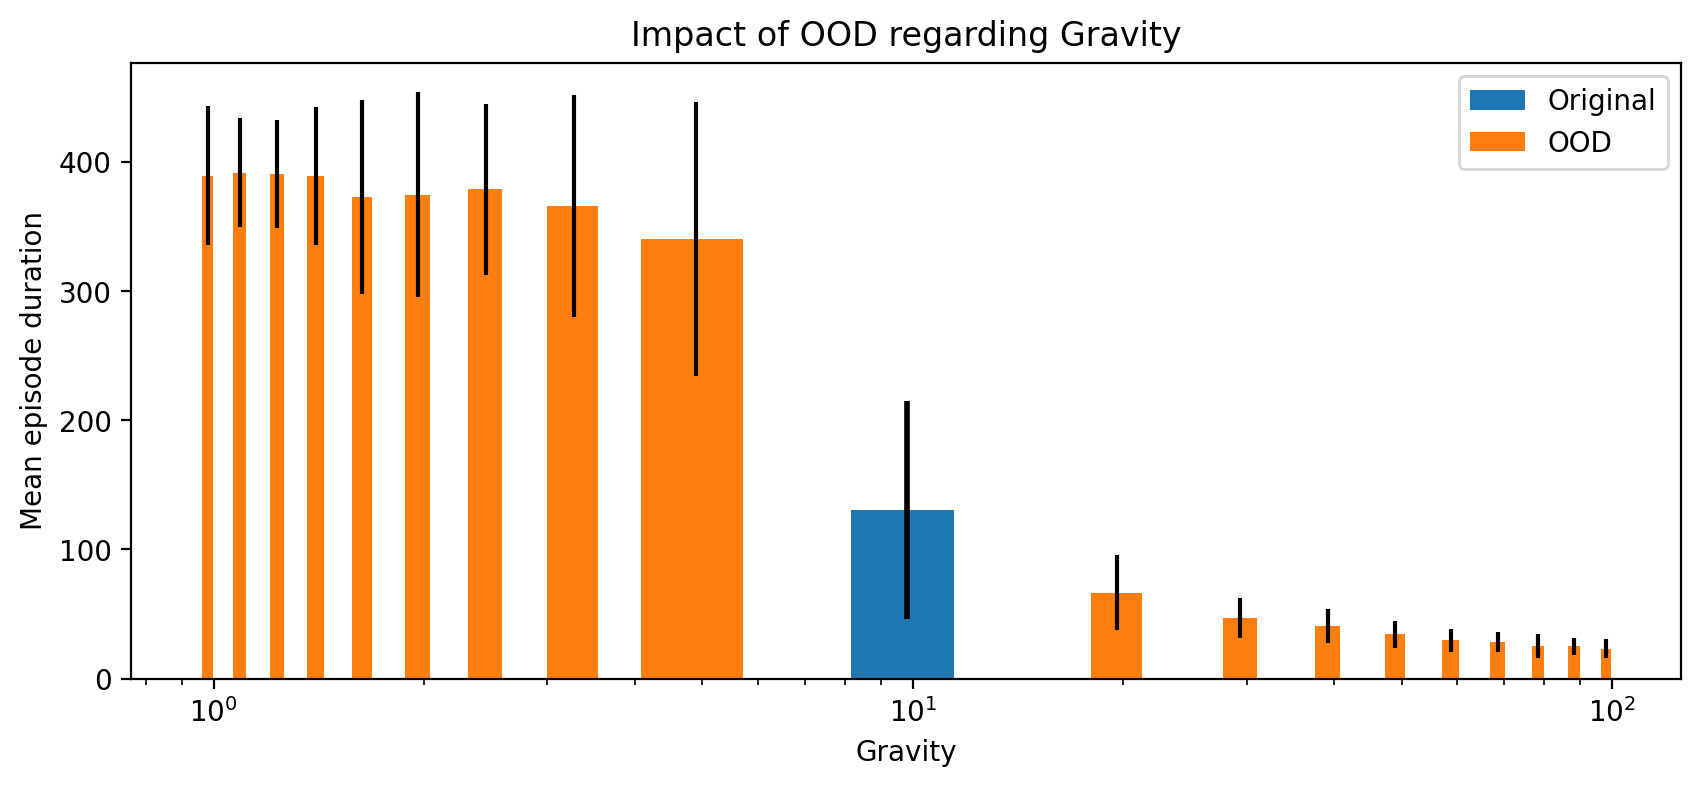

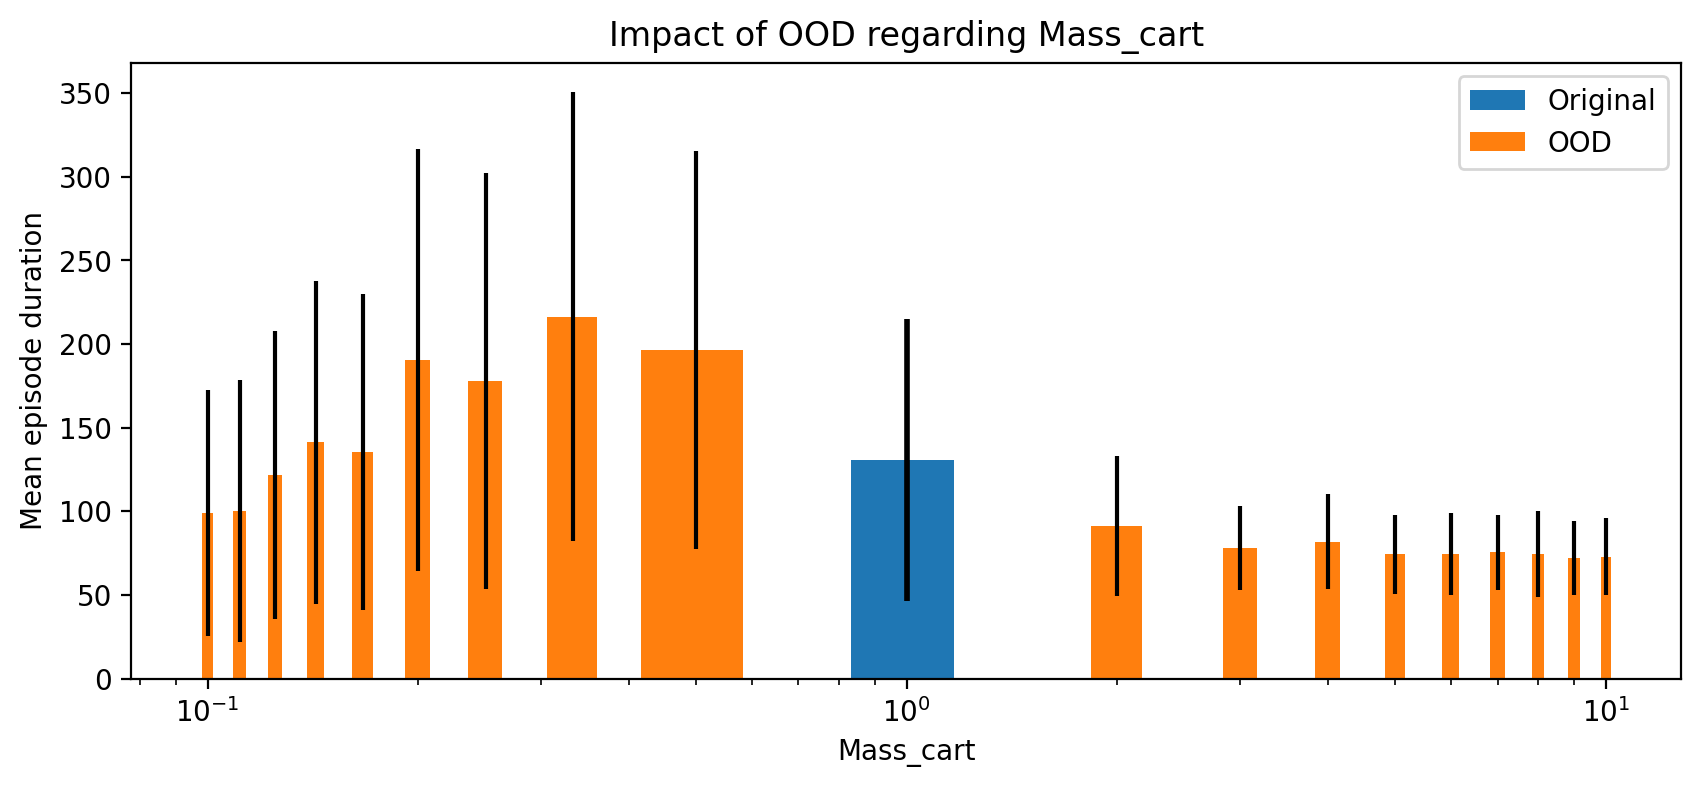

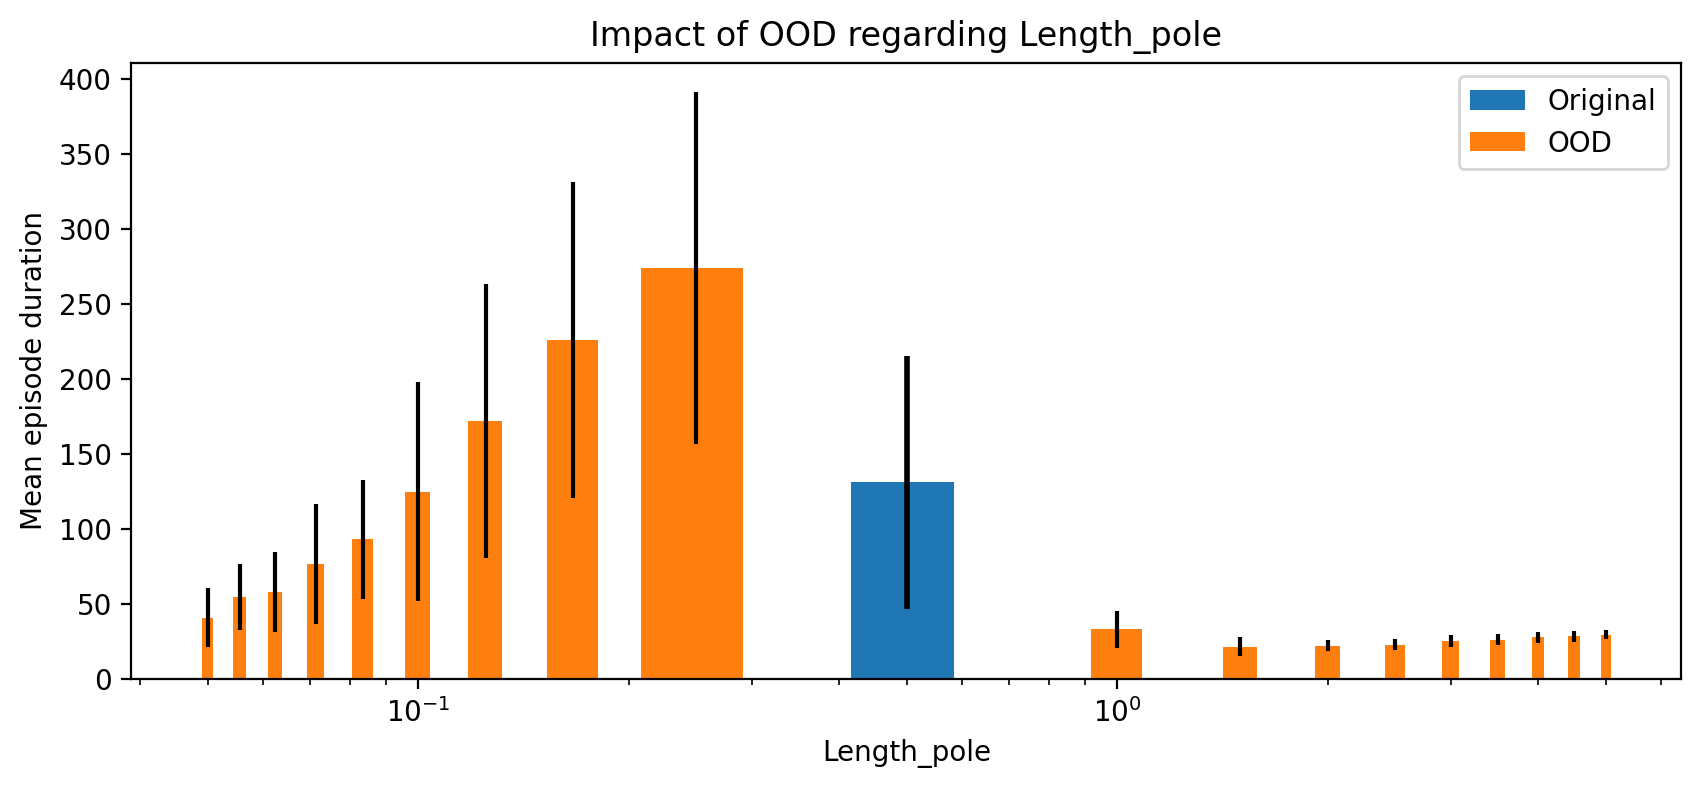

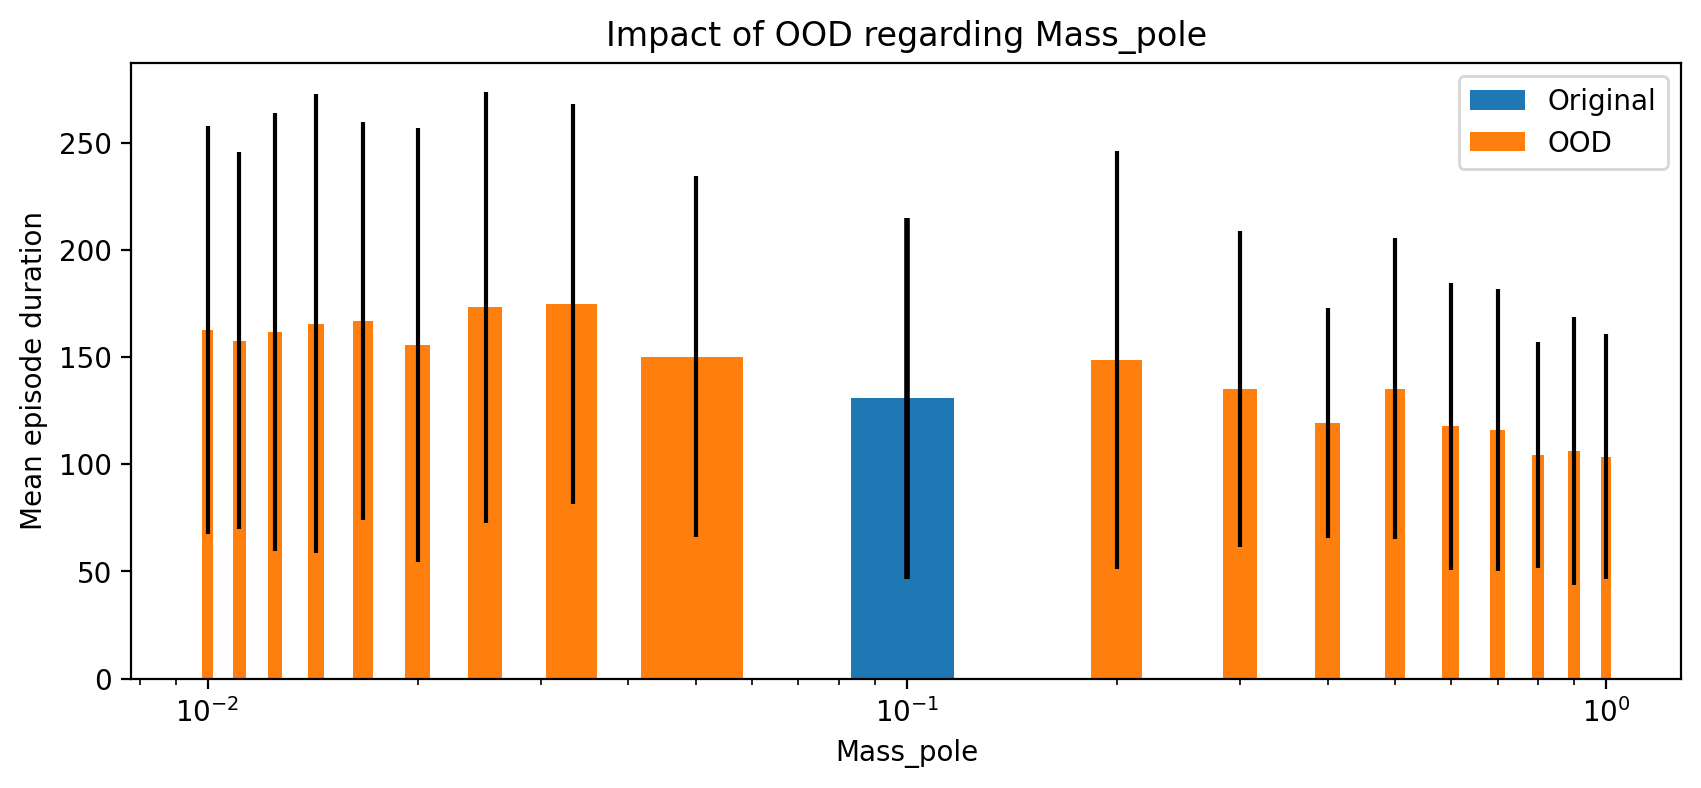

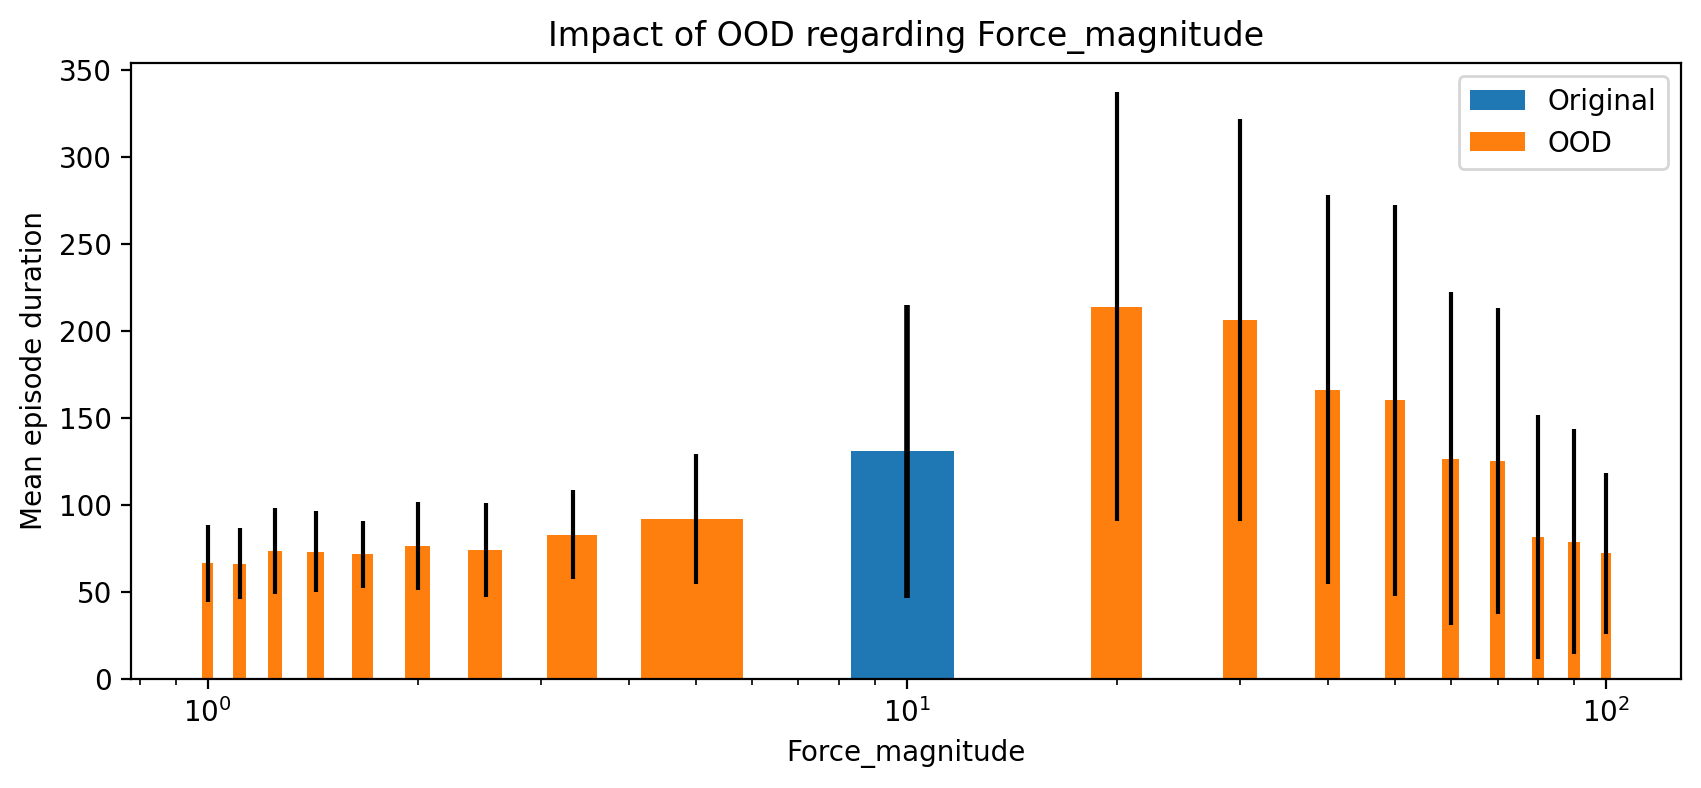

In [19]:
for key in results:
    fig, ax = plt.subplots(figsize=(10, 4), dpi=200)
    ax.set_xscale('log')
    
    labels = copy(values[key])
    labels.append(default_values[key])
    labels = sorted(labels)
    
    width = np.array(labels[1:]) - np.array(labels[:-1]) 
    width /= 3
    #print(width, np.array([width[-1]]))
    #width = np.concatenate((width, np.array([width[-1]])))/ 5
    #print(width)
    ax.bar(default_values[key], original_result, yerr=original_std_result, width=width, label='Original')

    ax.bar(values[key], results[key], yerr=std_results[key], width=width, label='OOD')
    
    ax.set_xlabel(key)
    ax.set_ylabel('Mean episode duration')
    ax.set_title('Impact of OOD regarding '+key)
    ax.legend()
    """
    ax.bar(str(default_values[key]), original_result, width=width)
    labels = [str(x) for x in values[key]]
    ax.bar(labels, results[key], width=width)
    """
    

# Create OOD detector

In [20]:
default_values, values = get_cartpole_values()
env = instanciate_cartpole(default_values)
ood_detector = MartingaleOODDetector(env, verbose=False)

In [21]:
default_values, values = get_cartpole_values()
ood_config = get_ood_configs(default_values, values)[-1]
ood_env = instanciate_cartpole(ood_config)
ood_config

{'Gravity': 9.8,
 'Mass_cart': 1.0,
 'Length_pole': 0.5,
 'Mass_pole': 0.1,
 'Force_magnitude': 100.0,
 'change': 'Force_magnitude'}

In [22]:
from tabnanny import verbose


ood_score = ood_detector.test_ood(ood_env, nb_steps=100)
ood_score

0.39217217496659434

In [75]:
ood_detector.get_in_distrib_score()

8.572937070799851e-05

In [31]:
default_values, values = get_cartpole_values()
mean_ood_scores = {}
std_ood_scores = {}

original_env = instanciate_cartpole(default_values)
agent = A2C.load(path/'Agents'/'trained_CartPole_10000', env=original_env)
ood_detector = MartingaleOODDetector(env)
in_distrib_score = ood_detector.get_in_distrib_score()

for config in tqdm(ood_configs):
    if config['change'] not in mean_ood_scores:
        mean_ood_scores[config['change']] = []
        std_ood_scores[config['change']] = []
    
    ood_env = instanciate_cartpole(config)
    agent = A2C.load(path/'Agents'/'trained_CartPole_10000', env=ood_env)
    list_scores = np.array([ood_detector.test_ood(ood_env, nb_steps=100) for _ in range(10)])
    ood_score = list_scores.mean()
    std_score = list_scores.std()

    #mean_reward, std_reward = evaluate(ood_env, agent, nb_episodes=10)

    mean_ood_scores[config['change']].append(ood_score)
    std_ood_scores[config['change']].append(std_score)
    #print(config, mean_reward)
    



100%|██████████| 90/90 [00:13<00:00,  6.51it/s]


In [24]:
in_distrib_score

9.456572098796185e-05

In [33]:
std_ood_scores

{'Gravity': [1.8119105675173484e-05,
  2.7676966879636197e-05,
  1.964537605515672e-05,
  1.3651686739112546e-05,
  2.0331280177579466e-05,
  1.860943971427866e-05,
  6.626605496183599e-06,
  1.4044789219652672e-05,
  1.3223774447667185e-05,
  1.828846011354828e-05,
  4.5592422318088865e-05,
  6.22686200889198e-05,
  3.7636626780954155e-05,
  3.907723499709078e-05,
  3.0077198276260038e-05,
  2.3661964754048296e-05,
  4.4673881132827554e-05,
  4.900423374076124e-05],
 'Mass_cart': [0.0038717356054360206,
  0.002952383026284288,
  0.00285622959086261,
  0.0049547376495867705,
  0.003932915459028204,
  0.0058849270075945715,
  0.009675853069532527,
  0.006258279512893213,
  0.023993308012443284,
  0.03694535040022748,
  0.025501217343405207,
  0.02397566974372614,
  0.023136652219845403,
  0.011996942733451716,
  0.019915720305623986,
  0.024517156596866013,
  0.020689422753472696,
  0.022257211453454752],
 'Length_pole': [2.2592385188160115e-05,
  1.595283343196176e-05,
  1.880432817541

100%|██████████| 5/5 [00:00<00:00, 48.69it/s]


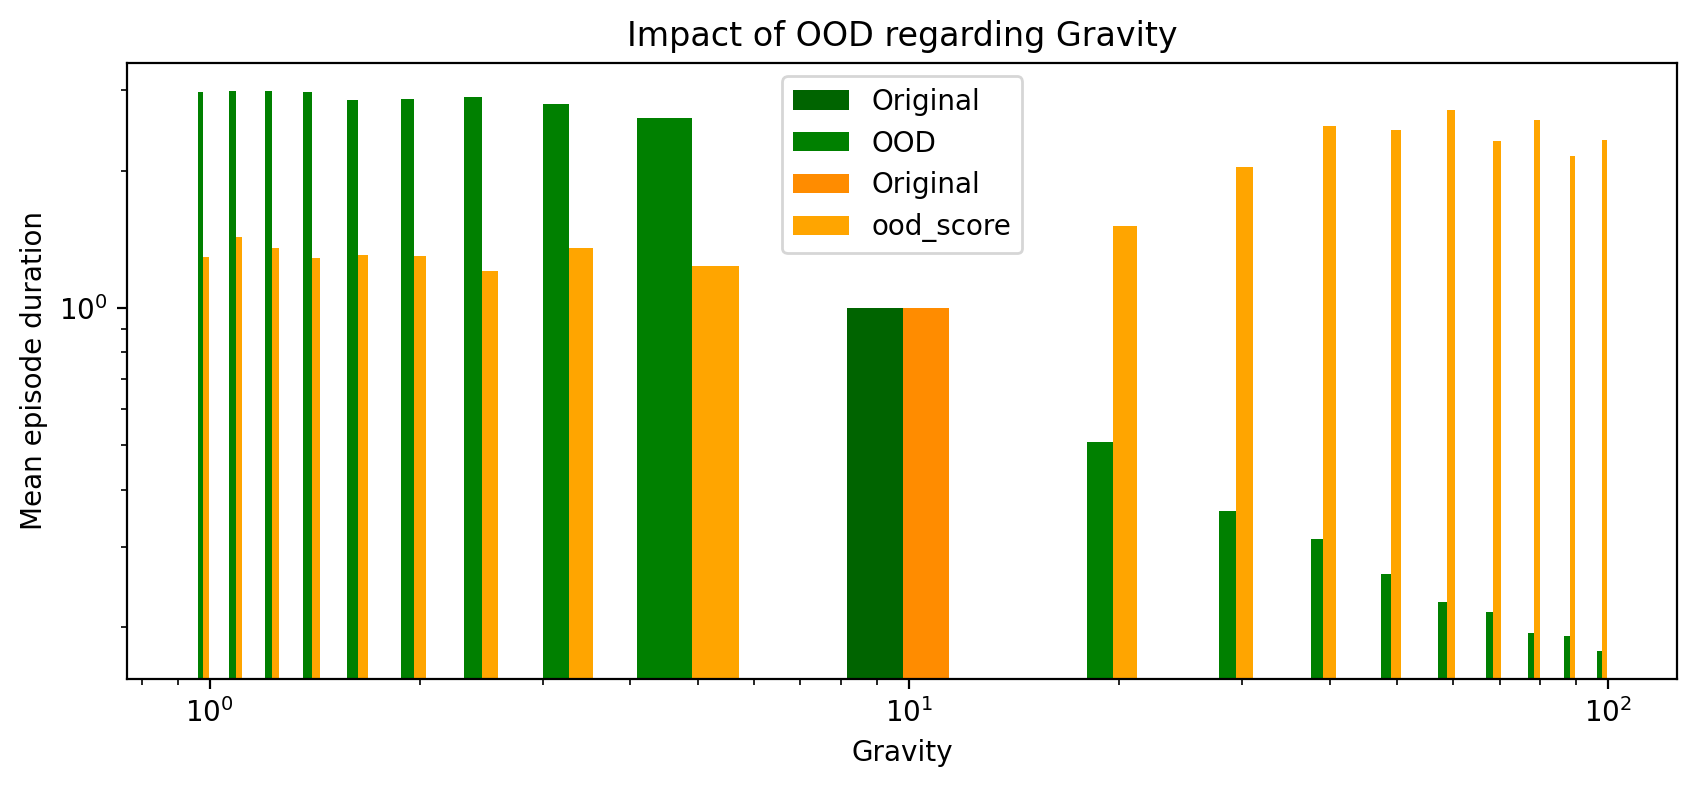

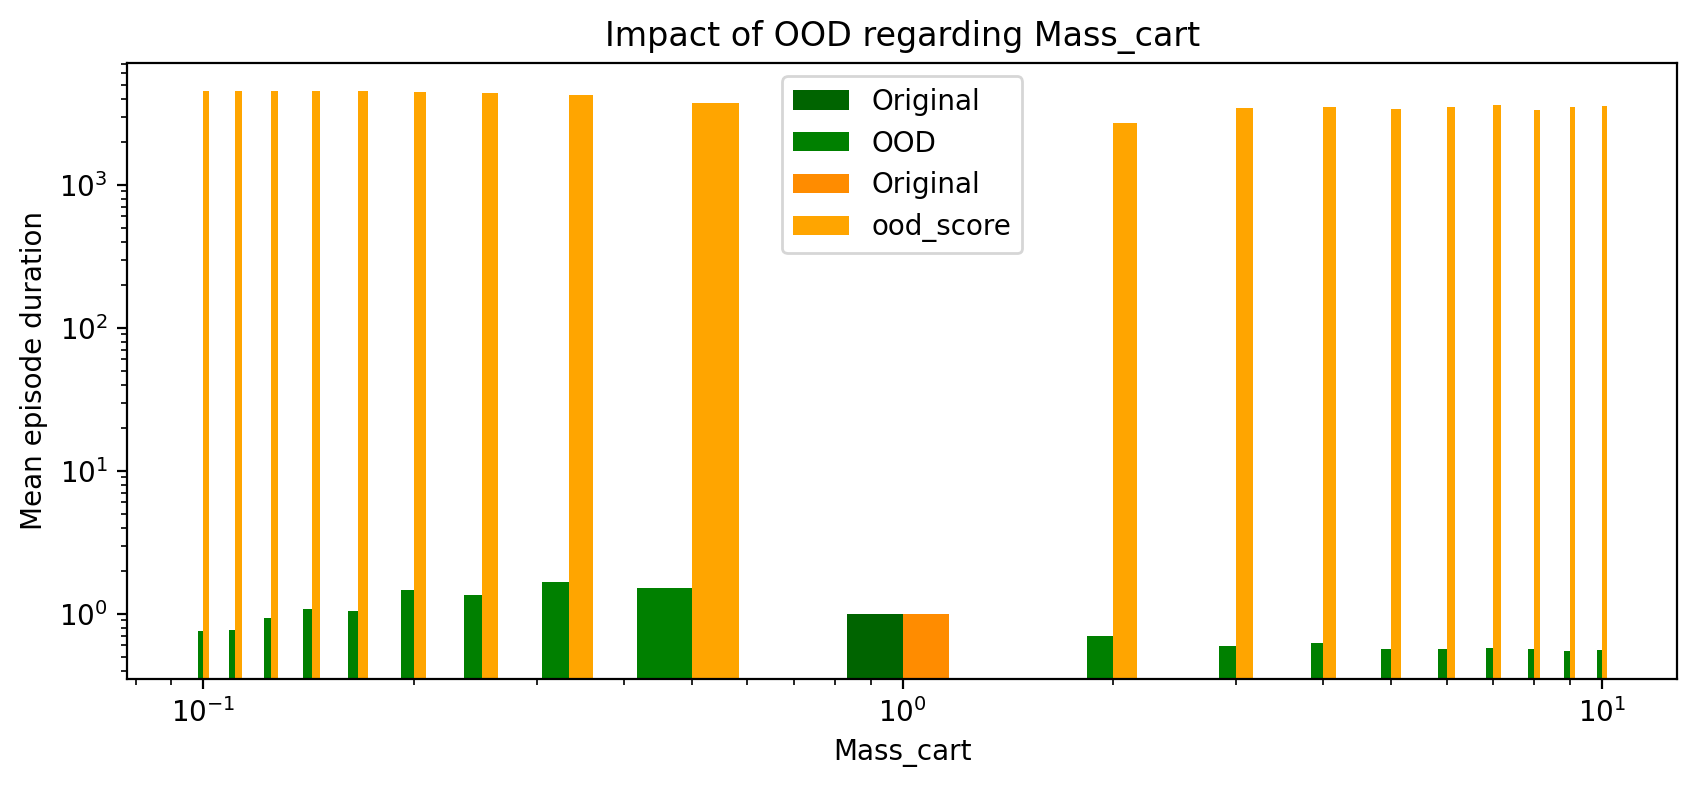

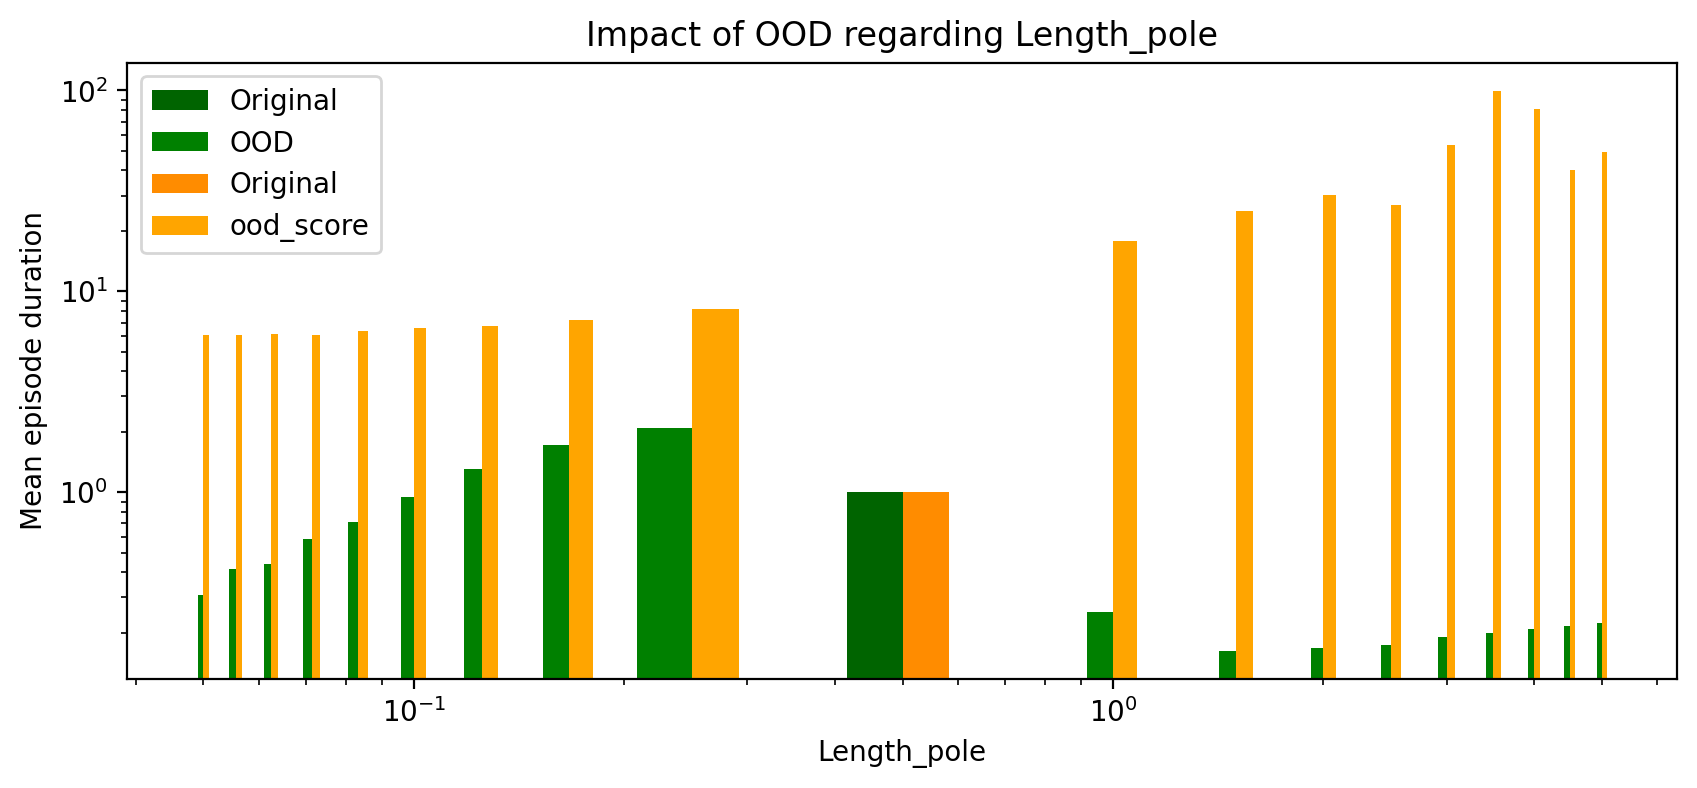

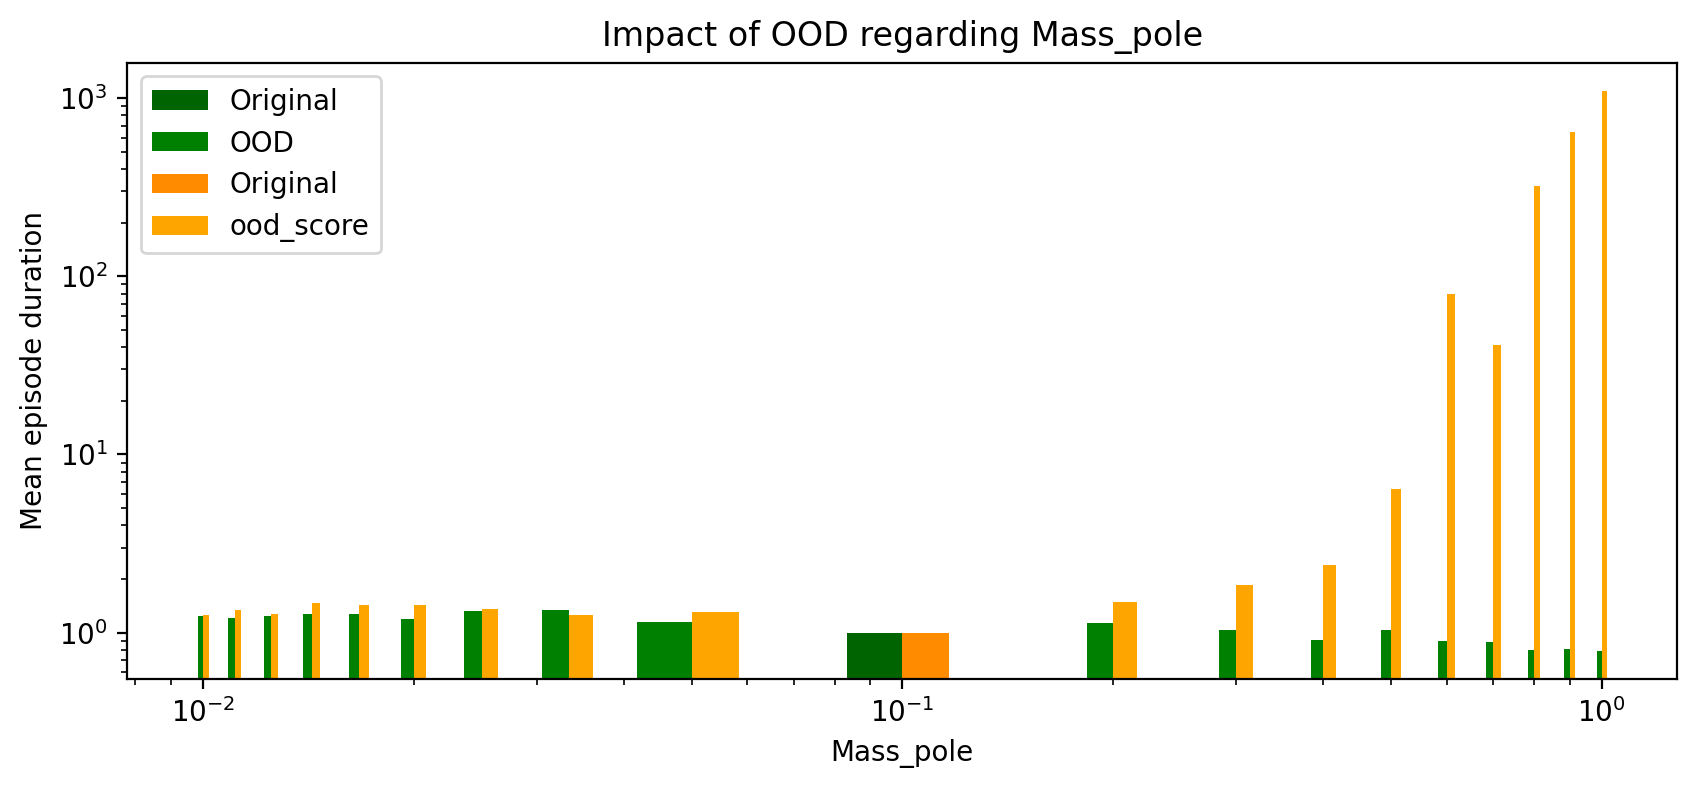

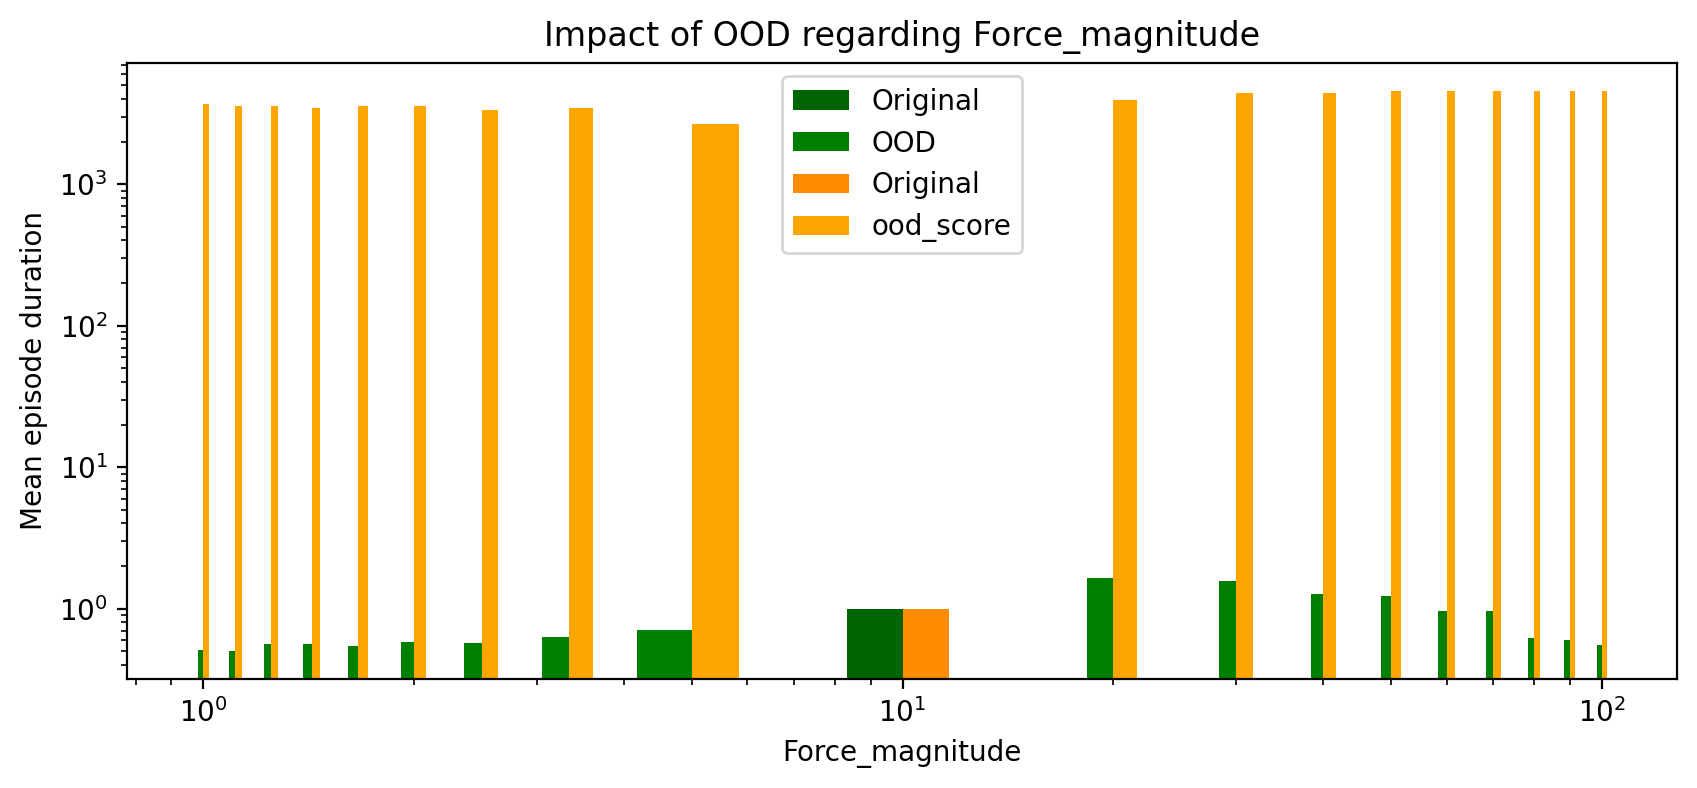

In [32]:
from turtle import color


for key in tqdm(results):
    fig, ax = plt.subplots(figsize=(10, 4), dpi=200)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    labels = copy(values[key])
    labels.append(default_values[key])
    labels = sorted(labels)
    
    width = np.array(labels[1:]) - np.array(labels[:-1]) 
    width /= 6
    #print(width, np.array([width[-1]]))
    #width = np.concatenate((width, np.array([width[-1]])))/ 5
    #print(width)

    ax.bar(default_values[key]- width/2, 1.0, width=width, label='Original', color='darkgreen')
    ax.bar(values[key]- width/2, results[key]/original_result, width=width, label='OOD', color='green')

    #ax.bar(default_values[key]- width/2, original_result, yerr=original_std_result, width=width, label='Original')
    #ax.bar(default_values[key]- width/2, in_distrib_score, width=width, label='Original ood_score')

    #ax.bar(values[key]- width/2, results[key], yerr=std_results[key], width=width, label='OOD')
    ax.bar(default_values[key]+width/2, 1.0, width=width, label='Original', color='darkorange')
    ax.bar(values[key]+ width/2, mean_ood_scores[key]/in_distrib_score, width=width, label='ood_score', color='orange', yerr=std_ood_scores[key])
    
    ax.set_xlabel(key)
    ax.set_ylabel('Mean episode duration')
    ax.set_title('Impact of OOD regarding '+key)
    ax.legend()
    """
    ax.bar(str(default_values[key]), original_result, width=width)
    labels = [str(x) for x in values[key]]
    ax.bar(labels, results[key], width=width)
    """

In [66]:
len(values['Gravity'])

18

In [49]:
[i for i in mean_ood_scores]

['Gravity', 'Mass_cart', 'Length_pole', 'Mass_pole', 'Force_magnitude']

In [82]:
original_env = instanciate_cartpole(default_values)
agent = A2C.load(path/'Agents'/'trained_CartPole_10000', env=original_env)
original_result, original_std_result = evaluate(original_env, agent, render=False)
original_std_result

84.62958997891931

In [120]:
mean_ood_scores['None'] = [evaluate(original_env, agent, render=False)[0] for _ in trange(5*18)]

100%|██████████| 90/90 [02:18<00:00,  1.54s/it]


In [89]:
mean_ood_scores

{'Gravity': [0.00011117337628771402,
  0.0001228965068135176,
  0.00011621845917342251,
  0.00011023711698065789,
  0.000112142482048035,
  0.00011145271928664651,
  0.00010344490278401894,
  0.00011586025255474022,
  0.0001058468429247116,
  0.00012948275395812094,
  0.00017507936265837248,
  0.00021496656568907824,
  0.0002102667630594459,
  0.00023252440307077455,
  0.00019909440471908686,
  0.00022135608270463193,
  0.0001842811885312905,
  0.00019990335974833057],
 'Mass_cart': [0.38859738327115323,
  0.3891141726000328,
  0.3908176949775067,
  0.3873620496595098,
  0.3897968388232137,
  0.38442858726897894,
  0.37689424800605265,
  0.3637264245297563,
  0.3188173062667429,
  0.23060248006433662,
  0.29661929204713644,
  0.2995637757978857,
  0.29026939062792106,
  0.3001696633349864,
  0.30984220582054467,
  0.2861857866671872,
  0.2998269213302832,
  0.3026108201339728],
 'Length_pole': [0.0005201274980499476,
  0.0005213841982942167,
  0.000525153256858788,
  0.0005209242624439

In [94]:
5*18

90

90 54
0.0 0.0
90 54
0.0 0.0
90 54
0.0 0.0
90 54
0.0 0.0
90 56
0.0 0.0
90 72
0.0 0.0
90 90
0.0 0.0
90 90
0.0 0.0
90 90
0.0 0.0
90 90
0.0 0.0
90 90
0.0 0.0
90 90
0.0 0.0
90 90
0.0 0.0
90 90
0.0 0.0
90 90
0.0 0.0
90 90
0.0 0.0
90 90
0.0 0.0
90 90
0.0 0.0
90 90
0.0 0.0
90 90
0.0 0.0
90 90
0.0 0.0
90 90
0.0 0.0
90 90
0.0 0.0
90 90
0.0 0.0
90 90
0.0 0.0
90 90
0.0 0.0
90 90
0.0 0.0
90 90
0.0 0.0
90 90
0.0 0.0
90 90
0.0 0.0
90 90
0.0 0.0
90 90
0.0 0.0
22 90
0.7555555555555555 0.43037974683544306
0 90
1.0 0.5
0 90
1.0 0.5
0 90
1.0 0.5
0 90
1.0 0.5
0 90
1.0 0.5
0 90
1.0 0.5
0 90
1.0 0.5
0 90
1.0 0.5
0 90
1.0 0.5
0 90
1.0 0.5
0 90
1.0 0.5
0 90
1.0 0.5
0 90
1.0 0.5
0 90
1.0 0.5
0 90
1.0 0.5
0 90
1.0 0.5
0 90
1.0 0.5
0 90
1.0 0.5
0 90
1.0 0.5
0 90
1.0 0.5
0 90
1.0 0.5
0 90
1.0 0.5
0 90
1.0 0.5
0 90
1.0 0.5
0 90
1.0 0.5
0 90
1.0 0.5
0 90
1.0 0.5
0 90
1.0 0.5


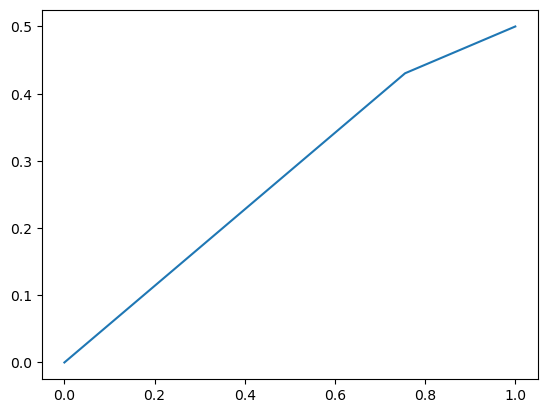

In [96]:


precisions = []
recalls = []
AUC = 0.0

n=5*18
#nb_threshold = 100
thresholds = [10**(i/10) for i in range(-10, 50+1)]
for threshold in thresholds:
    #print(threshold)
    false_pos=0
    false_neg=0

    for key in mean_ood_scores:
        if key != 'None':
            for test_res in mean_ood_scores[key]:

                if test_res<threshold:
                    false_neg +=1
        else:
            for test_res in mean_ood_scores[key]:

                if test_res>threshold:
                    false_pos +=1


    print(false_pos, false_neg)
    try:
        precision = (n-false_pos)/(n-false_pos+false_pos)
    except ZeroDivisionError:
        print('error')
        pass
        #tpr = 1.0
    
    try:
        recall = (n-false_pos)/(n-false_pos+false_neg)
    except ZeroDivisionError:
        print('error')
        pass
        #fpr = 1.0

    

    print(precision, recall)
    precisions.append(precision)
    recalls.append(recall)
    #AUC += tpr/len(thresholds)

    
#print('AUC: ', AUC)
plt.plot(precisions, recalls)

In [138]:
mean_ood_scores.keys()

dict_keys(['Gravity', 'Mass_cart', 'Length_pole', 'Mass_pole', 'Force_magnitude', 'None'])

In [143]:
len(mean_ood_scores['Mass_cart'])

18

In [158]:
n

90

100000.0
0 0
90 90

79432.82347242821
0 0
90 90

63095.7344480193
0 0
90 90

50118.72336272725
0 0
90 90

39810.71705534969
0 0
90 90

31622.776601683792
0 0
90 90

25118.864315095823
0 0
90 90

19952.62314968879
0 0
90 90

15848.93192461114
0 0
90 90

12589.254117941662
0 0
90 90

10000.0
0 0
90 90

7943.282347242814
0 0
90 90

6309.57344480193
0 0
90 90

5011.872336272725
0 0
90 90

3981.0717055349733
0 0
90 90

3162.2776601683795
0 0
90 90

2511.88643150958
0 0
90 90

1995.2623149688789
0 0
90 90

1584.893192461114
0 0
90 90

1258.9254117941675
0 0
90 90

1000.0
0 0
90 90

794.3282347242813
0 0
90 90

630.957344480193
0 0
90 90

501.18723362727246
0 0
90 90

398.1071705534973
0 0
90 90

316.22776601683796
0 0
90 90

251.18864315095797
0 0
90 90

199.52623149688787
0 0
90 90

158.48931924611142
0 22
90 68

125.89254117941675
0 90
90 0

100.0
0 90
90 0

79.43282347242814
0 90
90 0

63.09573444801933
0 90
90 0

50.11872336272722
0 90
90 0

39.810717055349734
0 90
90 0

31.6227766016837

Text(0, 0.5, 'FPR')

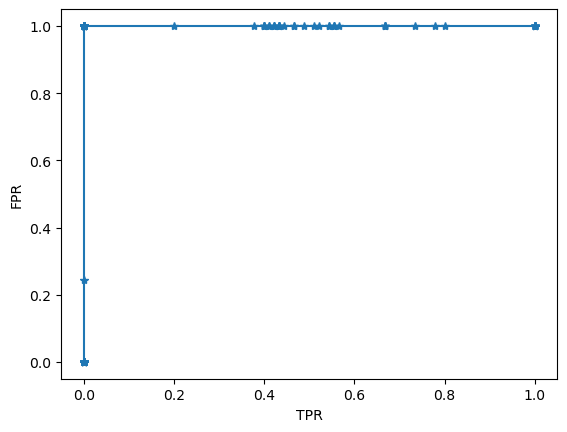

In [195]:


TPRs = []
FPRs = []
AUC = 0.0

n=5*18
#nb_threshold = 100
thresholds = [10**(-i/10) for i in range(-50, 50+1)]
for threshold in thresholds:
    false_pos=0
    false_neg=0
    true_pos=0
    true_neg=0

    for key in mean_ood_scores:
        if str(key) != 'None': # Env OOD
            for test_res in mean_ood_scores[key]:

                if test_res<threshold: # Not detected as OOD
                    false_neg +=1
                else:
                    true_pos +=1
        else: # Env standard
            for test_res in mean_ood_scores[key]:

                if test_res>threshold: # Detected as OOD
                    false_pos +=1
                else:
                    true_neg +=1


    try:
        tpr = true_pos/(true_pos+false_neg)
    except ZeroDivisionError:
        print('error tpr')
        continue
        tpr = 1.0
    
    try:
        fpr = false_pos/(false_pos+true_neg)
    except ZeroDivisionError:
        print('error fpr')
        continue
        fpr = 0.0
        """print(threshold)
        print(false_pos, false_neg)
        print('tpr', tpr, 'fpr', fpr)
        print()"""

    print(threshold)
    print(true_pos, false_pos)
    print(false_neg, true_neg)
    print()
    #print(precision, recall)
    TPRs.append(tpr)
    FPRs.append(fpr)
    #AUC += tpr/len(thresholds)

#TPRs.append(1.0)
#FPRs.append(1.0)
    
#print('AUC: ', AUC)
plt.plot(TPRs, FPRs,'-*')
plt.xlabel('TPR')
plt.ylabel('FPR')

In [196]:
import scipy
scipy.integrate.simps(x=TPRs, y=FPRs, even='avg')

0.925925925925926

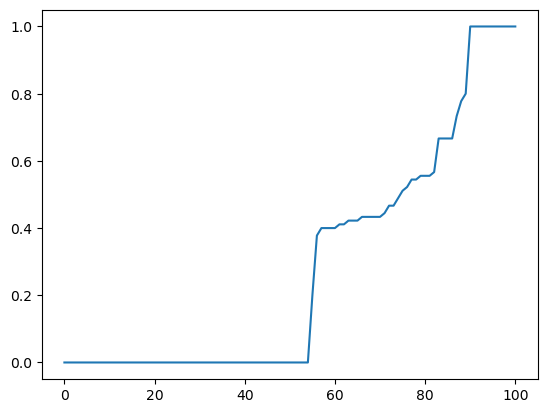

In [193]:
plt.plot(TPRs)

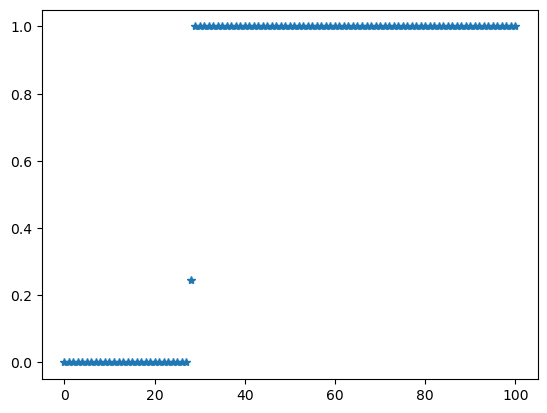

In [194]:
plt.plot(FPRs, '*')